In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
import yfinance as yf
import pandas as pd
from scipy.integrate import quad
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from math import*
from typing import Dict, Tuple
from numpy.polynomial.laguerre import laggauss
from scipy.stats import norm
from scipy.optimize import differential_evolution, minimize


In [2]:
T = 1      # horizon final
N = 1000   # nombre de pas
dt = T/N   # taille d’un pas
r = 0.05   # taux d
t = np.linspace(0, T, N)
W = np.zeros(N)

## Simulation d'un mouvement browien

Rappelons qu'un mouvement brownien est un processus stochastique $(W_t)_{t\geq0}$ tel que : 


- $W_0 = 0$ 
- Pour des temps $0< t_1, \dots, t_n < T$ les accroissements $W_{t_{i+1}} - W_{t_{i}} $ sont indépendants
- De plus, pour tout $t,s$,    $W_t - W_s \rightarrow \mathcal{N}(0,t-s)$



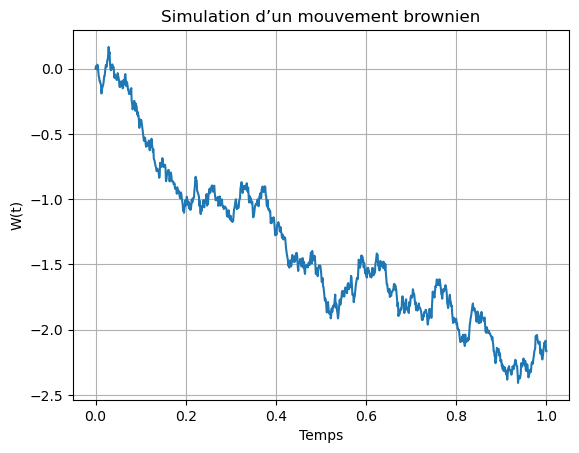

In [5]:
for i in range(1, N):
    W[i] = W[i-1] + np.sqrt(dt)*np.random.normal()

plt.plot(t, W)
plt.title("Simulation d’un mouvement brownien")
plt.xlabel("Temps")
plt.ylabel("W(t)")
plt.grid()
plt.show()

### Mouvements browniens corrélés $W_1,W_2$: 

On définit : 
 $$W_t^1 = \sqrt t Z_1, W_t^2 = \sqrt t  \left(\rho Z_1 + \sqrt{1-\rho^2}Z_2 \right) $$

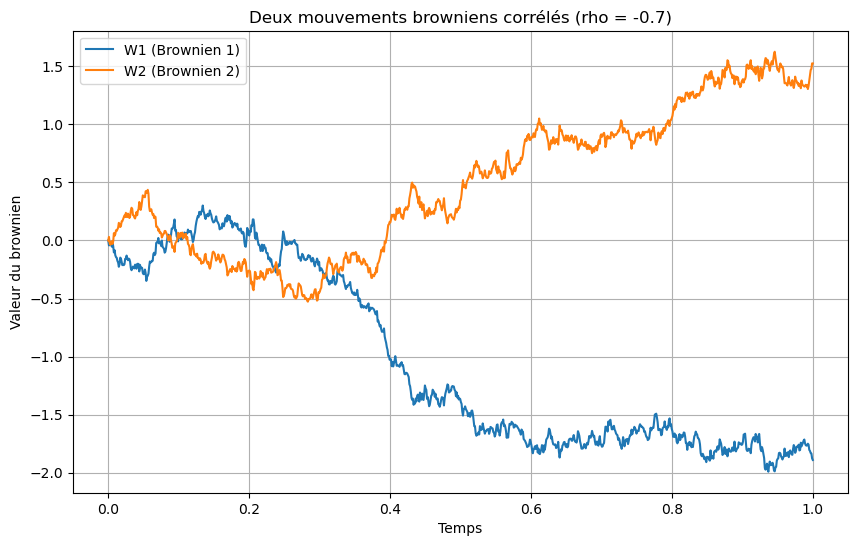

In [7]:
rho = -0.7

W_1 = np.zeros(N)
W_2 = np.zeros(N)

Z_1 = np.random.randn(N)
Z_2 = np.random.randn(N)

for i in range(N-1):
    dW_1 = np.sqrt(dt)*Z_1[i]
    dW_2 = np.sqrt(dt)*(rho*Z_1[i] + np.sqrt(1-rho**2)*Z_2[i])
    W_1[i+1] = W_1[i] + dW_1
    W_2[i+1] = W_2[i] + dW_2


plt.figure(figsize=(10, 6))
plt.plot(t, W_1, label='W1 (Brownien 1)')
plt.plot(t, W_2, label='W2 (Brownien 2)')
plt.title(f"Deux mouvements browniens corrélés (rho = {rho})")
plt.xlabel("Temps")
plt.ylabel("Valeur du brownien")
plt.legend()
plt.grid(True)
plt.show()


## - EDS vérifiée par le sous-jacent

Supposons que le prix du sous jacent $S_t$ suit un mouvement brownien géométrique i.e. : 

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$ 

- $\mu$ est le drift ou rendement moyen de l'actif
- $\sigma$ la volatilité supposée constante dans le modèle de Black-Scholes.
- $W_t$ un mouvement brownien.

On peut démontrer que, sous la mesure de risque neutre \mathcal{Q}, la solution est définie par : 

$$ S_t = S_0 \cdot exp\left((r-\sigma^2/2)t + \sigma W^Q_t\right).$$

Donc pour une valeur initiale $S_0$ donnée, on peut simuler une trajectoire de l'actif. 

## - Du modèle à la formule de pricing 

On sait que pour un call européen, le payoff de l'option est : 
$$ max(S_T - K,0), $$ où $S_T$ est le prix du sous-jacent à la maturité $T$ et $K$ le strike de l'option. 

On cherche à calculer la valeur de l'option aujourd'hui $t = 0$. 
Le prix de l'option est définie par l'espérance de gain "discounté". Formellement cela correspond à : 

$$ V_0 = e^{-rT}\mathbb{E^Q}\left( (S_T - K)^+ \right), $$

où $\mathbb{Q}$ est la mesure de risque neutre. 

## - De la mesure 'naturelle' vers la mesure de risque neutre  

On sait que l'actif $S_t$ vérifie l'EDS suivante sous la mesure $\mathbb{P}$.

$$ dS_t = \mu S_t dt + \sigma S_t dW^\mathbb{P}_t $$

On souhaite repasser à l'équation vérifiée par ce processus sous la mesure $\mathbb Q$. On utilisera le théorème de **Girsanov** dont l'énoncé est le suivant : 

# Théorème de Girsanov : 

Soit : 
- $W_t$ un mouvement brownien standard sous $\mathbb P$
- $\theta_t$ un processus adapté à une certaine filtration.

Alors : 

$$\tilde W_t = W_t + \int_0^t \theta_s ds. $$ est un mouvement brownien sous la mesure $\mathbb Q$.

Donc en posant $\theta = \frac{\mu - r}{\sigma}$. 

On a donc d'après le théorème de **Girsanov** que : 

$$dW^\mathbb{Q}_t = dW^\mathbb{P}_t + \theta dt $$. En remplaçant dans l'EDS vérifiée par $S_t$ sous $\mathbb P$, on obtient : 

$$ dS_t = r S_t dt + \sigma S_t dW^\mathbb{Q}_t $$

## Simulation de Monte Carlo pour pricer l'option :

On sait qu'à date d'aujourd'hui, la valeur de call est : 

$$ C_0 = e^{-rT}\mathbb{E^Q}\left( (S_T - K)^+ \right), $$

où $$ S_T = S_0 \cdot exp\left((r-\sigma^2/2)T + \sigma W^\mathbb Q_T\right).$$

Alors $$ S_T = S_0 \cdot exp\left((r-\sigma^2/2)T + \sigma \sqrt T Z\right).$$

où $Z \rightarrow \mathcal N (0,1) $ 

Simulons $N>>1$ trajectoires de $S_T$ càd : 

$$ S_T^{(i)} = S_0 \cdot exp\left((r-\sigma^2/2)T + \sigma \sqrt T Z^{(i)}\right).$$

Auquel cas : $C_0 =  \frac{1}{N} e^{-rT} \sum_{i=1}^{i=N} max(S_T^{(i)}-K,0)$ 



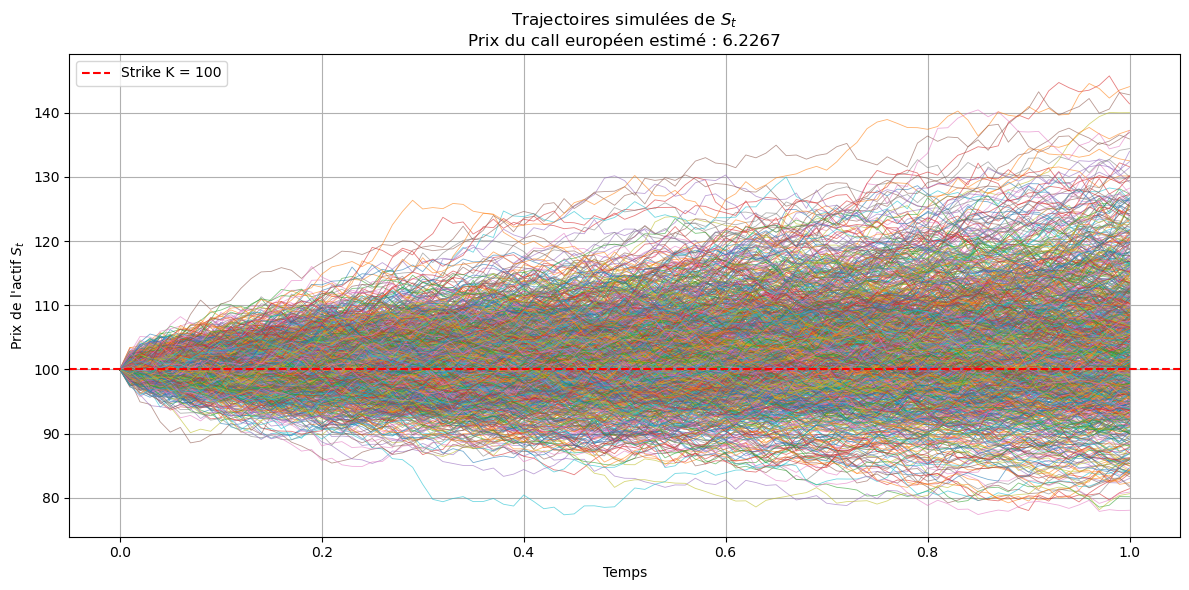

In [20]:
# Paramètres du modèle
S0 = 100         # Prix initial
K = 100          # Strike
r = 0.04         # Taux sans risque
sigma = 0.1      # Volatilité
T = 1            # Maturité (en années)
N = 10000      # Nombre de simulations de la trajectoire de S_t

# Étape 1 : Simulation de N valeurs de S_T (Black-Scholes)
Z_samples = np.random.normal(size=N)
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_samples)
payoffs = np.maximum(S_T - K, 0)

# Étape 2 : Estimation Monte Carlo du prix de l'option discounté
prix_MC = np.exp(-r * T) * np.mean(payoffs)

# Étape 3 : Affichage de trajectoires S_t (facultatif, on en prend moins)
nb_trajectoires = N     # pour visualisation
steps = 100               # nombre de pas de temps
dt = T / steps            # pas de temps

# On initialise les trajectoires
trajectoires = np.zeros((nb_trajectoires, steps + 1))
trajectoires[:, 0] = S0

# Simulation des trajectoires complètes de S_t
for i in range(1, steps + 1):
    Z = np.random.normal(size=nb_trajectoires)
    trajectoires[:, i] = trajectoires[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Étape 4 : Affichage
plt.figure(figsize=(12, 6))
t = np.linspace(0, T, steps + 1)
for i in range(1000):
    plt.plot(t, trajectoires[i], lw=0.6, alpha=0.6)

plt.axhline(y=K, color='red', linestyle='--', label='Strike K = 100')
plt.title(f"Trajectoires simulées de $S_t$\nPrix du call européen estimé : {prix_MC:.4f}")
plt.xlabel("Temps")
plt.ylabel("Prix de l'actif $S_t$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Performance de MC: 

Des résultats montrent que la valeur de l'option est dans un intervalle de confiance (à 95%): 

$$\hat{\mu} - \frac{1.96\sigma}{\sqrt N} < C < \hat{\mu} - \frac{1.96\sigma}{\sqrt N}.$$ avec $\hat \mu$ la moyenne obtenue

### Options Asiatiques 

Ce sont des options $strongly$ $path$ $dependent$, càd leur payoff dépend de la totalité/partie des trajectoires du cours du sous jacent. 
C'est le cas pour les **options asiatiques** car le payoff prend en compte la moyenne des valeurs du sous jacent sur toute la période de vie de l'option. 

Pour un **Call Asiatique** : 

$$payoff = max(\bar{S}-K,0)$$
Elles ont été inventées en Asie pour éviter les manipulation de prix le jour de la maturité. Elle s'achètent sur le marché **OTC**.

En général, les options Asiatiques sont moins chères que les options vanilles car elles sont moins volatiles. 

Il existe d'autres types d'options, notamment **Eurasian** et **Amerasian** options : ce sont des options asiatiques et qui dépendent juste de si on veut exercer à la maturité ou avant. 

#### Asian Strike option : 
Pour un **Asian Strike Call**, ça garantit au détenteur que la moyenne du sous-jacent ne dépassera pas le prix final. En d'autres termes, le payoff est : 
$$max(S_T - \bar{S},0).$$

Pour un put : 
$$max(\bar{S}-S_T,0).$$


### Méthode MC pour les Options Asiatiques : 

L'idée est de simuler $N$ trajectoires de $S_t$, pour chaque trajectoire on calcule sa moyenne $\bar S^{(i)}$ puis on calcule la moyenne des payoffs pour avoir le prix de l'option asiatique.  

Comme cela a été mentionné ci-dessus, une option asiatique est moins chère qu'une option européenne (pour les mêmes paramètres). 

Prix estimé de l'option asiatique (Monte Carlo) : 3.3058
Intervalle de confiance à 95% : [3.2257, 3.3859]


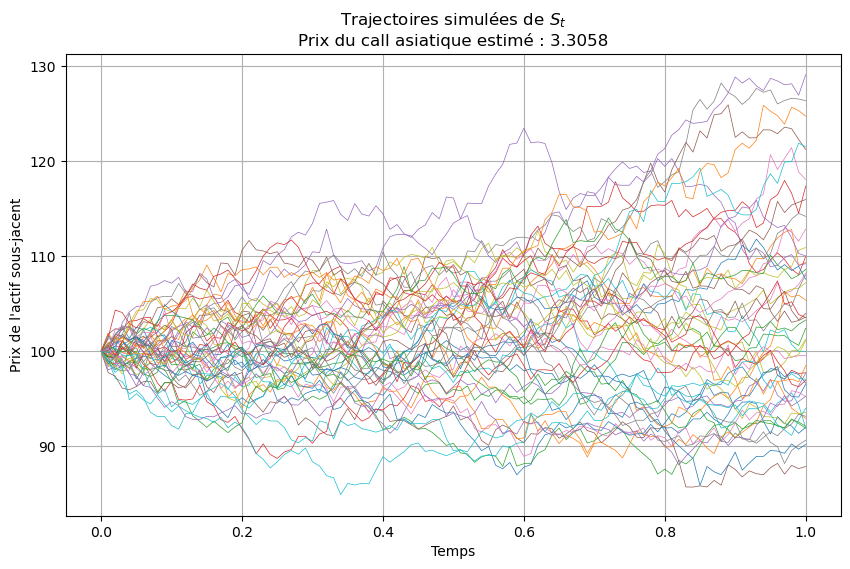

In [26]:

dt = T / steps    # Pas de temps
payoffs = []  # Liste des payoffs

trajectoires = []  # Pour stocker les trajectoires simulées

for i in range(N):
    S = [S0]
    for j in range(steps):
        Z = np.random.normal()
        S_next = S[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        S.append(S_next)
    trajectoires.append(S)
    S_moy = np.mean(S)  # Moyenne arithmétique
    payoff = max(S_moy - K, 0)
    payoffs.append(np.exp(-r * T) * payoff)

# Estimation du prix
payoffs = np.array(payoffs)
prix_MC = np.mean(payoffs)
ecart_type = np.std(payoffs, ddof=1)
intervalle_confiance = 1.96 * ecart_type / np.sqrt(N)

# Affichage des résultats
print(f"Prix estimé de l'option asiatique (Monte Carlo) : {prix_MC:.4f}")
print(f"Intervalle de confiance à 95% : [{prix_MC - intervalle_confiance:.4f}, {prix_MC + intervalle_confiance:.4f}]")

# Tracer quelques trajectoires
plt.figure(figsize=(10, 6))
for i in range(50):  # Tracer 50 trajectoires parmi les N
    plt.plot(np.linspace(0, T, steps + 1), trajectoires[i], lw=0.5)
    
plt.title(f"Trajectoires simulées de $S_t$\nPrix du call asiatique estimé : {prix_MC:.4f}")
plt.xlabel("Temps")
plt.ylabel("Prix de l'actif sous-jacent")
plt.grid(True)
plt.show()


## Quelques notions sur les options de devise 

Une option sur devise donne à son détenteur le droit, mais pas l'obligation, d'acheter une devise à un taux fixé (appelé **strike**), à une date future prédeterminée (appelée **maturité**) moyenne le paiement d'une **prime**. 
Elle peut être assimilée à une assurance, dans laquelle, au lieu de payer une prime pour assurer sa maison contre un risque d'incendie, le propriétaire paie une prime pour s'assurer contre des mouvements défavorables du taux de change. 

Dans notre cas l'actif sous-jacent est la devise. Pour une paire de devise ccy1/ccy2, ce sera le nombre d'unités nécessaires pour acheter une unité de ccy1. 


**Le put et call sur devise sont symétriques. De ce fait, un put permettant de vendre la devise A au taux de change K est équivalent à un call permettant d'acheter la devise B au taux de change $1/K$.**

#### Pricing des options sur devises

<center>
Prix de l'option = Valeur intrinsèque + Valeur temps
</center>

- La valeur intrinsèque correspond à la valeur minimale de la prime; elle correspond au gain immédiat, sans risque que ferait l'acheteur.
- La valeur temps reflète la probabilité que l'option devienne dans la monnaie. Elle est égale à la différence entre le prix de l'option et sa valeur intrinsèque. 

#### Effets des paramètres sur le prix d'options

- Spot price : Plus le spot **augmente**, plus le Call devient intéressant car on achèterait le sous-jacent à un prix (strike) inférieur au spot, donc la valeur du Call **augmente** aussi.
- Date d'échéance : Considérons deux options qui diffèrent uniquement de la maturité $T$. Le propriétaire de l'option à durée de vie plus longue profite de toutes les opportunités d'exercice ouvertes. Donc plus $T$ est grand, plus la valeur de l'option ($call ou put$) augmente.
- Volatilité : Le détenteur d'un call bénéficie d'une hausse du taux de change, mais limite son risque de perte restreint à la valeur de la prime de l'option. De même et inversement pour un put. Donc on a une augmentation de la valeur de l'option ($call ou put$) avec l'augmentation de la volatilité.


#### Un univers risque-neutre

Il présente deux caractéristiques principales : 

- La rentabilité attendue par les investisseurs est le taux sans risque.
- Le taux d'actualisation utilisé pour l'espérance des flux est aussi le taux sans risque. 

## Les Grecques : 

#### Delta

Le Delta d'une option est défini comme étant la variation du prix de l'option par rapport à prix du sous jacent. Formellement : 

$$ \Delta = \frac{\partial C}{\partial S}.$$ 
En gros en traçant la courbe du de $C = f(S)$, $\Delta$ correspond donc à la pente de la tengente à cette courbe en un point $S^*$.   


#### Gamma

Le Gamma d'un portefeuille d'options F, est le taux de variations du Delta par rapport au prix du sous jacent. Formellement, 

$$ \Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{\partial \Delta}{\partial S}.  $$ 
Le $\Gamma$ est toujours posifif et présente un maximum quand $S$ vaut $K$. 

#### Theta 

Le Theta d'une option est la variation du prix de l'option par rapport à la durée de vie de l'option: 

$$ \Theta = \frac{\partial C}{\partial T}. $$

Le theta d'une option est en général négatif car la valeur de l'option diminue lorsqu'on se rapproche de l'échéance. 

#### Vega

Le Vega d'une option représente le taux de variation de la valeur du portefeuille en fonction de la volatilité. 

$$ vega = \frac{\partial C}{\partial \sigma} $$ 

Le vega est toujours positif comme cela a été évoqué avant avec un maximum autour de K. 

### Limites du modèle Black-Scholes

Même si ça reste le modèle le plus utilisé pour pricer les options, il existe beaucoup d'inconsistances. 

- Le modèle suppose que $\sigma$ est constante, ce qui n'est pas du tout réaliste.
- Contrairement à l'hypothèse centrale du modèle, le prix du sous-jacent ne varie pas de façon continue.

Il s'agit en fait d'une aproximation de premier ordre du fonctionnement du marché. 


### Volatilité 

La volatilité $\sigma$ doit être estimé en général. Il existe plusieurs façons : 

#### Volatilité Historique :

La volatilité historique se base sur les données historiques des prix du sous jacent. Ce qui risque d'être compliqué c'est déterminer la période sur laquelle on veut estimer cette volatilité parce qu'on veut que les rendements soient indépendants et identiquement distribués. 

On choisit $n$ données et on calcule un estimateur empirique de l'écart-type. 

 **Choix de n** : Il est délicat en général de choisir $n$, car des fois c'est pas pertinent de prendre beaucoup trop de valeurs anciennes qui vont pas forcément refléter les valeurs futures. La règle générale est de choisir cette période égale à l'horizon d'investissement. 


#### Volatilité implicite : 

En connaissant le prix du marché de l'option, on peut trouver une valeur unique à cette volatilité appelée **volatilité implicite**. En gros cette volatilité si on l'injecte dans la formule de Black-Sholes ça devrait nous donner le prix du marché. 
**C'est une prédiction de la volatilité d'un certain actif à partir du prix du marché de l'option.** 

La courbe de volatilité implicite en fonction du strike $K$ nous donne deux formes : 
- Smile de volatilité (symétrique) : Les options deep-in-the-money et out-of-the-money sont plus volatiles que les options at-the-money.
- Skew de volatilité (asymétrique) : Les options out-of-the-money sont plus volatiles que les autres options.



## Le régime de change marocain 

Avant, le Maroc adoptait un régime de change fixe où la valeur du dirham était fixé à partir d'un panier de devises. Historiquement ce panier était principalement composé de devises européennes ainsi que le dollar américain avant la création de l'Euro comme monnaie unique entre les pays européens. 

Mais à partir de 2015, ce panier est composé de l'Euro et le dollar américain avec des pondérations respectives de 60% et 40%. Le Maroc cherche donc à "libéraliser" le dirham marocain en laissant l'offre et la demande déterminer la valeur du dirham dans le marché par rapport aux autres devises. 

Avant de passer à un régime flottant, Bank Al-Maghrib a procédé à deux phases, pour l'instant, afin de flexibiliser le dirham par rapport à USD et EUR. 
Cela s'est concrétisé en 2018 en élargissant la bande de fluctuation à +/- 2.5% au lieu de +/- 0.3% avant, puis en mars 2020 où la bande était encore plus élargie à +/- 5% par rapport à un cours central fixé par Bank Al-Maghrib. 


#### Implications de ce régime de change sur l'économie Marocaine : 

La volonté de passer à un régime de change flottant implique que la banque centrale ne déterminera plus le cours EUR/MAD ou USD/MAD mais c'est plutôt la dynamique de l'offre et la demande qui vont déterminer cela. 

Par exemple : 

- Si des investisseurs étrangers viennent massivement au Maroc, une forte demande du dirham serait nécessaire et donc une appréciation du dirham puisqu'ils chercheront à convertir leur devise en dirham et vice-versa.


#### Le pouvoir d'achat : 
- Si le dirham finit par se déprécier, ce qui va forcément être le cas en vue du déficit dans la balance commerciale, l'importation de matières premières par exemple (essentielle à l'économie marocaine puisqu'on a pas de souveraineté en termes de MP) va coûter encore plus cher et donc le pouvoir d'achat va fortement diminuer.

#### Assèchement des liquidités : 
- Le seul levier qui restera à la portée de la Banque Centrale pour soutenir le dirham en cas d'appréciation ou dépréciation brutale est de puiser dans les réserves de devises pour acheter/vendre du dirham afin d'équilibrer le cours du dirham. Mais cela va assécher les réserves de change.

#### Risques de spéculation : 
- Les hedge funds peuvent parier sur la baisse du dirhams et faire de la vente à découvert. Le Maroc n'est pas en mesure de contrer ces mouvements massives, ce qui va encore faire déprécier le dirham. Cela a déjà été produit en 1992 lors des attaques spéculatives sur la livre sterling. 

## Modèle de volatilité stochastique 

#### Modèle de Heston : 

L'un des problèmes majeurs de la formule de Black-Scholes c'est qu'elle suppose que la volatilité $\sigma$ est constante, ce qui est loin d'être vraie. 
Le modèle de Heston permet d'avoir une variation et du prix du sous-jacent et de la volatilité. 

On suppose que le prix du sous-jacent $S_t$ et la volatilité $V_t$ suivent les processus suivants : 

$$ dS_t = (r_d-r_f)S_tdt + \sqrt V_t S_t dW_{1t} $$ 
$$ dV_t = \kappa(\theta - V_t)dt + \sigma \sqrt V_t dW_{2t} $$

Et on suppose que les deux MB sont corrélés avec un facteur $\rho \in [-1,1]$ 

**$\theta$ : variance en régime permanent**

**$\kappa$ : vitesse de retour à $\theta$**




Dans la formule d'Heston, on utilise une fonction caractéristique pour établir la formule d'un **call européen** $C(t)$ à un instant $t$ étant donnés le strike $K$ et la maturité $T$.  

Ces formules font intervenir naturellement les paramètres $(\kappa, \theta, r, \sigma, \rho)$. Ces paramètres vont en général être estimés numériquement via une maximisation de vraissemblance ou la méthode des moments. En utilisant l'historique des données sur une paire de devises, on peut estimer des valeurs numériques de ces paramètres. 


On utilise la méthode de discrétisation d'Euler et en prenant $dt=1$ : 

$$ S_{t+1} = S_t + (r_d-r_f)S_t + \sqrt V_t S_t Z_s $$ 

Pour des questions de simplification, on pose $Q_{t+1} = \frac{S_{t+1}}{S_t}$ on a : 

$$ Q_{t+1} = 1 + (r_d-r_f) + \sqrt V_t Z_s, $$ avec $Z_s \rightarrow \mathcal N(0,1) $ 

De même pour le processus $V_t$. 

$$V_{t+1} = V_t + \kappa(\theta - V_t) + \sigma \sqrt V_t Z_v, $$ avec $Z_v \rightarrow \mathcal N(0,1)$

Pour imposer la corrélation $\rho$ entre $Z_s$ et $Z_v$, on pose $Z_v \underset{def}{=} Z_1$ et $Z_s = \rho Z_1 + \sqrt{1-\rho^2} Z_2 $ où $Z1,Z_2 \rightarrow \mathcal N (0,1)$ et indépendants. On obtient donc le système : 

$$ Q_{t+1} = 1 + (r_d-r_f) + \sqrt V_t \rho Z_1 + \sqrt{1-\rho^2} Z_2, $$
$$ V_{t+1} = V_t + \kappa(\theta - V_t) + \sigma \sqrt V_t Z_1. $$ 

### Méthode des Moments pour estimer ($\kappa, \nu_0, \theta, \sigma, \rho$): 

On note $\mu_j = \mathbb{E}(Q^j_{t+1})$ le $j$-ème moment de la variable aléatoire $Q_{t+1}$.  

On estime les paramètres ($\kappa, \nu_0, \theta, \sigma, \rho$) selon l'algorithme suivant : 

- écrire les $m$ moments en fonction des $m$ paramètres qu'on cherche à estimer.
- Calculer les moments empiriques à partir des données càd $\hat \mu_j = \mu_j$ où $\hat \mu_j = \frac{1}{n}\sum_{t=1}^n Q^j_{t+1}.$
- En faisant ça, on obtient un système de $m$ inconnues et $m$ équations.
- On résout le système et on obtient l'estimation $\hat \alpha_{mom}$ du paramètre  $\alpha$.


Le calcul théorique des 5 moments est fastidieux, je le détaillerai plus tard si j'en ai besoin. 

### Estimateur de Maximum de Vraissemblance :  

Cette méthode utilise des algorithmes d'optimisation pour trouver les paramètres ($\kappa, r_d, r_f, \theta, \sigma, \rho$) qui maximisent la vraissemblance définie par : 

$$L(\kappa, \nu_0, \theta, \sigma, \rho) = \prod_{t=1}^n f(Q_{t+1},V_{t+1} | \kappa, r_d, r_f, \theta, \sigma, \rho)$$

On peut utiliser, pour simplifier, la log-vraissemblance : 

$$l(\kappa, \nu_0, \theta, \sigma, \rho) = \sum_{t=1}^n  log \left(f(Q_{t+1},V_{t+1} | \kappa, \nu_0, \theta, \sigma, \rho) \right)$$

Optimiser $L$ est équivalent à optimiser $l$. On calcule les dérivées partielles de cette quantités par rapport à chaque paramètre et on l'annule : l'argument du maximum correspond donc à l'estimation de notre paramètre. 

Pour ce faire, il nous faut une expression explicite de la densité $f$, d'après la discrétisation d'Euler, on peut dire que : 

$$ Q_{t+1} \rightarrow \mathcal N (1+r_d-r_f,V_t), V_{t+1} \rightarrow \mathcal N (V_t + \kappa(\theta - V_t),\sigma^2V_t)$$ et en utilisant le fait que $Z_s$ et $Z_v$ ont une corrélation $\rho$. On peut déduire une densité $f$ un peu complexe que je n'explicite pas ici. 




### Calibration du modèle : 

In [52]:
# charger les données historiques EUR/MAD du 16/07/24 au 11/07/25

df = pd.read_csv("EUR_MAD.csv", sep=",", encoding="utf-8")
df = df[['Date', 'Dernier']].copy()
df['Dernier'] = df['Dernier'].str.replace(',', '.').astype(float)
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.sort_values('Date').reset_index(drop=True)

# afficher un aperçu
print(df)
print(df['Dernier'])

          Date  Dernier
0   2024-07-16  10.7070
1   2024-07-17  10.7350
2   2024-07-18  10.6867
3   2024-07-19  10.6998
4   2024-07-22  10.7059
..         ...      ...
254 2025-07-07  10.5523
255 2025-07-08  10.5614
256 2025-07-09  10.5471
257 2025-07-10  10.5375
258 2025-07-11  10.5327

[259 rows x 2 columns]
0      10.7070
1      10.7350
2      10.6867
3      10.6998
4      10.7059
        ...   
254    10.5523
255    10.5614
256    10.5471
257    10.5375
258    10.5327
Name: Dernier, Length: 259, dtype: float64


On voit que $V_t$ est la variance de $Q_{t+1}$, donc on va estimer cette variance de la sorte : 

$$V_t = Var(Q_1, \dots, Q_{t+1})$$

In [54]:
S = df["Dernier"].astype(float).values[::-1]

Q = np.array([S[i+1] / S[i] for i in range(len(S) - 1)])

def build_variance_series(Q):  
    V = [0.001]
    for i in range(1, len(Q)):
        V.append(np.var(Q[:i+2], ddof=1))
    return np.array(V)


In [55]:
def log_likelihood(params, Q):
    kappa, theta, sigma, rho = params

    # Penalités pour éviter valeurs trop proches de zéro
    penalty = 0
    if kappa < 1e-3: penalty += 1e6
    if theta < 1e-3: penalty += 1e6
    if sigma < 1e-3: penalty += 1e6
    if abs(rho) > 0.999: penalty += 1e6

    if penalty > 0:
        return 1e10 + penalty

    
    # Contraintes naturelles du modèle de Heston
    if not (0 < sigma and 0 < kappa and 0 < theta and -0.999 < rho < 0.999 and 2 * kappa * theta >= sigma**2):
        return np.inf

    # Constantes (fixées, pas calibrées ici)
    r_d = 0.045
    r_f = 0.0215

    V = build_variance_series(Q)
    
    Q_tp1 = Q[2:]
    V_t = V[:-2]
    V_tp1 = V[1:-1]

    loglik = 0
    for i in range(len(Q_tp1)):
        delta_Q = Q_tp1[i] - 1 - (r_d - r_f)
        delta_V = V_tp1[i] - V_t[i] - kappa * (theta - V_t[i])

        try:
            term1 = -np.log(2 * np.pi)
            term2 = -np.log(sigma)
            eps = 1e-8
            vti = max(V_t[i], eps)
            term3 = -np.log(V_t[i])
            term4 = -0.5 * np.log(1 - rho**2)
            A = (delta_Q**2) / (2 * V_t[i] * (1 - rho**2))
            B = rho * delta_Q * delta_V / (sigma * V_t[i] * (1 - rho**2))
            C = (delta_V**2) / (2 * sigma**2 * V_t[i] * (1 - rho**2))

            loglik += term1 + term2 + term3 + term4 - A + B - C
        except:
            return np.inf  # sécurité si division par 0 ou log de négatif

    return -loglik  # car on minimise


In [56]:
x0 = [0.8, 0.05, 0.05, -0.3]   # kappa, theta, sigma, rho

bounds = [
    (1e-8, 5),    # kappa
    (1e-8, 5),    # theta
    (1e-8, 5),    # sigma
    (-0.999, 0.999),  # rho
]


def constraint_2ktheta_gt_sigma2(params):
    kappa, theta, sigma, rho = params
    return 2 * kappa * theta - sigma**2 - 1e-4

nonlinear_constraint = {
    'type': 'ineq',
    'fun': constraint_2ktheta_gt_sigma2
}

result = minimize(
    log_likelihood,
    x0,
    args=(Q,),
    bounds=bounds,
    constraints=[nonlinear_constraint],
    method='SLSQP',
    options={'disp': True},
)

# === 6. Résultats ===
if result.success:
    kappa_hat, theta_hat, sigma_hat, rho_hat, v0_hat = result.x
    print("\n✅ Paramètres calibrés (Heston) :")
    print(f"kappa  = {kappa_hat:.5f}")
    print(f"theta  = {theta_hat:.5f}")
    print(f"sigma  = {sigma_hat:.5f}")
    print(f"rho    = {rho_hat:.5f}")
    print(f"v_0    = {v0_hat:.5f}")
else:
    print("❌ Échec de l'optimisation :", result.message)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 13845128.219996722
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
❌ Échec de l'optimisation : Inequality constraints incompatible


### Chargement de données des options sur EUR/USD 

In [58]:
# Chargement des données
df = pd.read_csv("EURUSD1.csv")

# Aperçu
#print(df)

# On stocke les listes utiles
maturities = df["DaysUntil"].values/365  # en années
strikes = df["Strike"].values
market_prices = df["Mid"].values

print(strikes)

[1.205 1.2   1.115 1.12  1.125 1.13  1.135 1.14  1.145 1.15  1.21  1.16
 1.155 1.19  1.185 1.195 1.175 1.17  1.165 1.18  1.2   1.125 1.19  1.185
 1.18  1.175 1.17  1.195 1.155 1.16  1.205 1.15  1.145 1.14  1.135 1.13
 1.215 1.22  1.165 1.21  1.145 1.13  1.22  1.215 1.21  1.205 1.2   1.195
 1.19  1.125 1.185 1.17  1.165 1.16  1.155 1.15  1.14  1.135 1.18  1.175
 1.125 1.215 1.205 1.2   1.195 1.19  1.185 1.18  1.175 1.22  1.17  1.16
 1.155 1.15  1.145 1.14  1.135 1.13  1.165 1.21  1.14  1.225 1.145 1.15
 1.155 1.16  1.165 1.17  1.175 1.185 1.19  1.195 1.2   1.205 1.21  1.215
 1.22  1.135 1.18  1.23  1.155 1.215 1.21  1.205 1.2   1.195 1.19  1.185
 1.18  1.175 1.17  1.165 1.16  1.15  1.145 1.14  1.135 1.13  1.22  1.225
 1.23  1.14  1.225 1.22  1.215 1.21  1.205 1.2   1.195 1.19  1.235 1.18
 1.15  1.155 1.16  1.145 1.17  1.175 1.165 1.185 1.23  1.19  1.225 1.22
 1.215 1.21  1.205 1.2   1.195 1.185 1.175 1.18  1.135 1.14  1.145 1.16
 1.155 1.165 1.17  1.15  1.24  1.235 1.23  1.225 1.22  1.2

### Calibrage du modèle (minimiser les moindres carrés)

In [60]:
r = 0.045-0.0215
S0 = 1.1590

v0 = 0.2

def heston_characteristic_function(u, S0,r, K, T, kappa, theta, sigma, rho):
   xi = kappa - rho * sigma * 1j * u
   d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2))
   g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
   C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
   D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
   return np.exp(C + D * v0 + 1j * u * np.log(S0))

# Define functions to compute call and put options prices
def heston_call_price(S0, K, r, T, kappa, theta, sigma, rho):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho))
   integral, _ = quad(integrand, 1e-10, 100, limit=200)
   return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral


test_price = heston_call_price(S0, K=strikes[0], r=r, T=maturities[0], kappa=1, theta=0.04, sigma=0.3, rho=-0.3)
print("Test call price :", test_price)

Test call price : 0.18563828842177144


In [61]:
def calibration_objective(params, S0, r, market_prices, strikes, maturities):
    kappa, theta, sigma, rho = params
    print(f"Essai avec params : kappa={kappa:.6f}, theta={theta:.6f}, sigma={sigma:.6f}, rho={rho:.6f}")
    
    model_prices = []
    for i in range(len(market_prices)):
        K = strikes[i]
        T = maturities[i]
        try:
            model_price = heston_call_price(S0, K, r, T, kappa, theta, sigma, rho)
        except Exception as e:
            print(f"  ⚠️ Erreur sur option {i}: {e}")
            return 1e10
        model_prices.append(model_price)

    model_prices = np.array(model_prices)
    error = model_prices - market_prices
    rmse = np.sqrt(np.mean(error**2))
    print(f"  → RMSE: {rmse:.6f}")
    return rmse

In [ ]:
x0 = [0.7, 0.04, 0.3, 0.5]  # initial guess
bounds = [(1e-6, 5), (1e-6, 5), (1e-6, 5), (-0.999, 0.999)]  # contraintes

result = dual_annealing(
    calibration_objective,
    bounds,
    args=(S0, r, market_prices, strikes, maturities),
    maxiter=100,
    seed=42
)

print("Paramètres calibrés :", result.x)
print("RMSE finale :", result.fun)

Essai avec params : kappa=1.872701, theta=4.753572, sigma=3.659970, rho=0.197120
  → RMSE: 0.611894
Essai avec params : kappa=3.214346, theta=0.134372, sigma=0.001616, rho=0.861896
  → RMSE: 0.799897
Essai avec params : kappa=2.340399, theta=1.399874, sigma=1.267118, rho=-0.780308
  → RMSE: 0.698592
Essai avec params : kappa=3.255066, theta=3.600581, sigma=2.181785, rho=0.812170
  → RMSE: 0.514430
Essai avec params : kappa=1.280024, theta=1.625539, sigma=4.121585, rho=0.018481
  → RMSE: 0.737114
Essai avec params : kappa=4.537527, theta=1.625539, sigma=4.121585, rho=0.018481
  → RMSE: 0.664451
Essai avec params : kappa=4.537527, theta=1.429966, sigma=4.121585, rho=0.018481
  → RMSE: 0.675021
Essai avec params : kappa=4.537527, theta=1.429966, sigma=0.002239, rho=0.018481
  → RMSE: 0.650725
Essai avec params : kappa=4.537527, theta=1.429966, sigma=0.002239, rho=-0.457879
  → RMSE: 0.650757
Essai avec params : kappa=3.255066, theta=3.600581, sigma=2.181785, rho=0.812170
  → RMSE: 0.51443

C:\Users\Ismail\AppData\Local\Temp\ipykernel_6908\2885784266.py:17: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 1e-10, 100, limit=200)


  → RMSE: 0.491637
Essai avec params : kappa=3.192634, theta=3.555675, sigma=2.281578, rho=0.999000
  → RMSE: 0.491637
Essai avec params : kappa=3.192634, theta=3.555675, sigma=2.281578, rho=0.999000
  → RMSE: 0.491637
Essai avec params : kappa=3.192634, theta=3.555675, sigma=2.281578, rho=0.999000
  → RMSE: 0.491637
Essai avec params : kappa=3.192634, theta=3.555675, sigma=2.281578, rho=0.999000
  → RMSE: 0.491637
Essai avec params : kappa=3.254251, theta=3.599995, sigma=2.183087, rho=0.814608
  → RMSE: 0.513348
Essai avec params : kappa=3.254251, theta=3.599995, sigma=2.183087, rho=0.814608
  → RMSE: 0.513348
Essai avec params : kappa=3.254251, theta=3.599995, sigma=2.183087, rho=0.814608
  → RMSE: 0.513348
Essai avec params : kappa=3.254251, theta=3.599995, sigma=2.183087, rho=0.814608
  → RMSE: 0.513348
Essai avec params : kappa=3.254251, theta=3.599995, sigma=2.183087, rho=0.814608
  → RMSE: 0.513348
Essai avec params : kappa=3.239344, theta=3.589231, sigma=2.198134, rho=0.836416


### Surface de vol : 

Dans le modèle de Garmann, la valeur d'un call est : 

$$C = Se^{-r_fT}\mathcal N(d_1)-Ke^{-r_dT}\mathcal N(d_2)$$ où 

$$d_1 = \frac{ln(S/K) + (r_d-r_f+0.5\sigma^2)T}{\sigma \sqrt T}, d_2 = d_1 - \sigma\sqrt T$$ 

Il n'y a pas de formule explicite pour la volatilité, donc on va plutôt extraire de la data sur les prix d'options observées dans le marché, puis trouver les $\sigma$ qui minimisent : 

$$|prix_{marche} - prix_{garman}|$$

In [ ]:
from scipy.stats import norm
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jax import grad
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import plotly.express as px
from scipy.stats import norm

In [ ]:
def garman_kohlhagen_call(S, K, T, r_d, r_f, sigma):
    """
    S peut être scalaire, K, T, sigma scalaires ou arrays broadcastables.
    Renvoie un array de même shape que K & T.
    """
    S     = np.asarray(S,     dtype=float)
    K     = np.asarray(K,     dtype=float)
    T     = np.asarray(T,     dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    F  = S * np.exp((r_d - r_f) * T)
    sig_sqrtT = sigma * np.sqrt(T)

    # éviter les divisions 0/0
    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / sig_sqrtT
        d2 = d1 - sig_sqrtT

    call = np.exp(-r_d * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))

    # cas T<=0 ou sigma<=0 : valeur intrinsèque
    intrinsic = np.maximum(S - K, 0.0)
    mask = (T <= 0) | (sigma <= 0)
    return np.where(mask, intrinsic, call)

In [ ]:
## Trouver le sigma 'optimal' en minimisant une certaine fonction de coût loss_func

def solve_for_iv(S,K,T,r_d,r_f,price,sigma_guess=0.8, N_iter=20, epsilon=0.001, verbose=True):
    converged = False 

    # make a guess for the implied volatility
    sigma = sigma_guess
    for i in range(N_iter):
        loss_val = loss_func(S, K, T, r_d, r_f, sigma,price)

        if verbose:
            print(f"Iteration {i+1}: Loss = {loss_val:.6f}, Sigma = {sigma:.6f}")


        # check if the loss is less than the tolerance epsilon : 
        if abs(loss_val) < epsilon:
            converged = True
            break

        else : 
            loss_grad_val = vega_garman_kohlhagen(S, K, T, r_d, r_f, sigma)
            if verbose:
                print(f"Loss gradient: {loss_grad_val:.6f}")

            sigma -= loss_val / loss_grad_val  # update the guess for sigma
            if verbose:
                print(f"Updated sigma: {sigma:.6f}")

    if not converged:
        print("Implied volatility did not converge")
    return sigma, converged


## Calcul du gradient de C = dérivée parielle par rapport à sigma = Vega 
def vega_garman_kohlhagen(S, K, T, r_d, r_f, sigma):
    S     = np.asarray(S,     dtype=float)
    K     = np.asarray(K,     dtype=float)
    T     = np.asarray(T,     dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    F  = S * np.exp((r_d - r_f) * T)
    sig_sqrtT = sigma * np.sqrt(T)

    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / sig_sqrtT

    vega = np.exp(-r_d * T) * F * norm.pdf(d1) * np.sqrt(T)
    vega = np.where((T <= 0) | (sigma <= 0), 0.0, vega)
    return vega

In [ ]:
def loss_func(S, K, T, r_d, r_f, sigma_guess, price):
    theo_price = garman_kohlhagen_call(S, K, T, r_d, r_f, sigma_guess)
    return theo_price - price

In [ ]:
ivs = []
r_d = 0.045
r_f = 0.02
S = 1.1590

for i in range(len(market_prices)):
    K = strikes[i]
    T = maturities[i]
    market_price = market_prices[i]
    
    iv, converged = solve_for_iv(S, K, T, r_d, r_f, market_price, verbose=False)
    ivs.append(float(iv))

print(ivs)

In [ ]:
### Tracé de la surface de volatilité

fig = plt.figure(figsize=(8, 5),dpi=100)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(strikes,maturities, ivs, cmap='viridis',linewidth=0.1,antialiased=True, alpha=0.8)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5,aspect=5, pad=0.1)
cbar.set_label('Implied volatility', rotation=270, labelpad=15)
ax.set_xlabel("Strike (K)",labelpad=10)
ax.set_ylabel("Maturité (T)",labelpad=10)
ax.set_zlabel("Volatilité implicite",labelpad=10)
ax.set_title("Surface de volatilité")

ax.view_init(elev=35,azim=40)

plt.tight_layout()

plt.show()


In [ ]:

T = df["DaysUntil"].values / 365.0      # maturité en années
K = df["Strike"].values                 # strikes
C_mkt = df["Mid"].values                # prix bid/ask milieu

S0  = 1.1570        # spot EUR/USD (à ajuster)
r_d = 0.045        
r_f = 0.0215 


K_arr = df["Strike"].values.astype(float).copy()
T_arr = (df["DaysUntil"].values / 365.0).astype(float).copy()
C_mkt = df["Mid"].values.astype(float).copy()

In [ ]:
def d1_d2(F, K, T, vol):
    sigT = vol*np.sqrt(T)
    d1 = (np.log(F/K) + 0.5*vol**2*T) / sigT
    d2 = d1 - sigT
    return d1, d2

In [ ]:
def price_call(S0, K, T, r_d, r_f, vol):
    F = S0*np.exp((r_d - r_f)*T)
    d1, d2 = d1_d2(F, K, T, vol)
    return np.exp(-r_d*T)*(F*norm.cdf(d1) - K*norm.cdf(d2))

In [ ]:
def implied_vol_vectorized(S, K, T, r_d, r_f, price,
                           sigma0=0.3, n_max=30, eps=1e-8):
    """
    Newton–Raphson vectorisé pour trouver IVs d'une série de prix.
    Renvoie un array de mêmes dimensions que price.
    """
    sigma = np.full_like(price, sigma0, dtype=float)
    for _ in range(n_max):
        price_theo = garman_kohlhagen_call(S, K, T, r_d, r_f, sigma)
        vega       = vega_garman_kohlhagen(S, K, T, r_d, r_f, sigma)
        diff       = price_theo - price
        # Condition d'arrêt globale
        if np.max(np.abs(diff)) < eps:
            break
        sigma -= diff / np.maximum(vega, 1e-12)
    return np.clip(sigma, 1e-4, None)   # borne plancher


In [ ]:
### Fonction caractéristique de Heston 

def heston_cf(u: np.ndarray, T: float, X0: float,
              kappa: float, theta: float, sigma: float, rho: float, v0: float,
              rd: float, rf: float) -> np.ndarray:
    u = np.asarray(u, dtype=np.complex128)
    i = 1j
    a = kappa * theta
    b = kappa
    d = np.sqrt((rho * sigma * i * u - b)**2 + sigma**2 * (u**2 + i * u))
    g = (b - rho * sigma * i * u - d) / (b - rho * sigma * i * u + d)  # phi2 stable
    C = (rd - rf) * i * u * T + (a / sigma**2) * ((b - rho * sigma * i * u - d) * T
                                                  - 2.0 * np.log((1.0 - g * np.exp(-d * T)) / (1.0 - g)))
    D = ((b - rho * sigma * i * u - d) / sigma**2) * ((1.0 - np.exp(-d * T)) / (1.0 - g * np.exp(-d * T)))
    return np.exp(C + D * v0 + i * u * np.log(X0))


In [ ]:
## Calcul d'intégrales P1 et P2

def _P1P2_integrals(X0: float, K: float, T: float,
                    rd: float, rf: float,
                    kappa: float, theta: float, sigma: float, rho: float, v0: float,
                    u_max: float = 200.0, N: int = 20000):
    du = u_max / N
    u = np.linspace(0.0, u_max, N + 1)
    k = np.log(K)
    i = 1j
    phi_vals = heston_cf(u, T, X0, kappa, theta, sigma, rho, v0, rd, rf)
    phi_minus_i = heston_cf(np.array([-1j]), T, X0, kappa, theta, sigma, rho, v0, rd, rf)[0]
    integrand_P2 = np.zeros_like(u, dtype=float)
    integrand_P1 = np.zeros_like(u, dtype=float)
    uu = u[1:]
    integrand_P2[1:] = np.real(np.exp(-i * uu * k) * phi_vals[1:] / (i * uu))
    phi_shift = heston_cf(uu - 1j, T, X0, kappa, theta, sigma, rho, v0, rd, rf)
    integrand_P1[1:] = np.real(np.exp(-i * uu * k) * phi_shift / (i * uu) / phi_minus_i)
    w = np.ones_like(u)
    w[1:-1:2] = 4.0
    w[2:-2:2] = 2.0
    I1 = du / 3.0 * np.sum(w * integrand_P1)
    I2 = du / 3.0 * np.sum(w * integrand_P2)
    P1 = 0.5 + (1.0 / pi) * I1
    P2 = 0.5 + (1.0 / pi) * I2
    return P1, P2

In [ ]:
## Formule de pricing de Heston

def call_price_integral(X0: float, K: float, T: float,
                        rd: float, rf: float,
                        kappa: float, theta: float, sigma: float, rho: float, v0: float,
                        u_max: float = 200.0, N: int = 20000) -> float:
    P1, P2 = _P1P2_integrals(X0, K, T, rd, rf, kappa, theta, sigma, rho, v0, u_max, N)
    return X0 * np.exp(-rf * T) * P1 - K * np.exp(-rd * T) * P2


In [ ]:
def price_heston_vectorized(param_tuple, S, Ks, Ts,
                            rd=r_d, rf=r_f, u_max=150.0, N=6000):

    Ks = np.asarray(Ks, dtype=float)
    Ts = np.asarray(Ts, dtype=float)

    # broadcast s’il n’y a qu’une seule maturité
    if Ts.ndim == 0 or Ts.size == 1:
        Ts = np.full_like(Ks, Ts)          # répète la valeur unique
    if Ks.shape != Ts.shape:
        raise ValueError(f"Ks ({Ks.shape}) et Ts ({Ts.shape}) doivent avoir la même longueur")

    kappa, theta, sigma, rho, v0 = param_tuple
    return np.array([
        call_price_integral(S, k, t, rd, rf,
                            kappa, theta, sigma, rho, v0,
                            u_max=u_max, N=N)
        for k, t in zip(Ks, Ts)
    ])


IV_mkt  = implied_vol_vectorized(S0, K, T, r_d, r_f, C_mkt)
vega_w  = vega_garman_kohlhagen(S0, K, T, r_d, r_f, IV_mkt)


In [ ]:
print("K_arr len:", len(K_arr), "   T_arr len:", len(T_arr))
assert len(K_arr) == len(T_arr) == len(C_mkt)

In [ ]:
def objective(params):
    kappa, theta, sigma, rho, v0 = params

    # bornes physiques dures
    if (kappa<=0) or (theta<=0) or (sigma<=0) or (v0<=0) or not (-0.95<rho<0.95):
        return 1e12

    C_model = price_heston_vectorized(params, S=S0, Ks=K, Ts=T)

    err = (C_model - C_mkt) / vega_w
    feller_pen = max(0.0, 0.25*sigma**2 - kappa*theta)  # >0 si Feller violée

    return np.sqrt(np.mean(err**2)) + 1e3 * feller_pen

In [ ]:
bounds = [(0.0005, 8.0),     # kappa
          (1e-4, 10),     # theta
          (0.005, 3.0),     # sigma
          (-0.95, 0.95),    # rho
          (1e-4, 5)]     # v0

print("Phase 1 – Differential Evolution (global)…")
T = df["DaysUntil"].values / 365.0      

res_de = differential_evolution(objective, bounds,
                                maxiter=120, popsize=15,
                                strategy='best1bin',
                                tol=1e-3, seed=1, polish=False)

print("→ point DE :", res_de.x)

print("Phase 2 – L-BFGS-B (local)…")
res_lbfgs = minimize(objective, res_de.x,
                     method='L-BFGS-B', bounds=bounds)

print("\n===========  CALIBRATION TERMINÉE  ===========")
print(f"kappa = {res_lbfgs.x[0]:.4f}")
print(f"theta = {res_lbfgs.x[1]:.4f}")
print(f"sigma = {res_lbfgs.x[2]:.4f}")
print(f"rho   = {res_lbfgs.x[3]:.4f}")
print(f"v0    = {res_lbfgs.x[4]:.4f}")
print("RMSE pondérée :", res_lbfgs.fun)